# Breast Cancer RNA-seq Classification

## Objective
To classify tumor vs normal breast tissue samples using bulk RNA-seq transcriptomic data and supervised machine learning models.

## 1. Data Loading

We load the raw RNA-seq count matrix and the corresponding sample metadata from GEO (GSE58135).

In [1]:
import pandas as pd

counts = pd.read_csv("/content/GSE58135_raw_counts_GRCh38.p13_NCBI.tsv",
                     sep="\t",
                     index_col=0)

print("Counts shape:", counts.shape)
counts.head()

Counts shape: (39376, 165)


,GSM1401648,GSM1401649,GSM1401650,GSM1401652,GSM1401653,GSM1401654,GSM1401655,GSM1401656,GSM1401657,GSM1401658,...,GSM1401806,GSM1401807,GSM1401808,GSM1401809,GSM1401810,GSM1401811,GSM1401812,GSM1401813,GSM1401814,GSM1401815
GeneID,,,,,,,,,,,,,,,,,,,,,
100287102,30,6,4,4,20,10,39,11,7,13,...,11,28,25,5,11,30,9,14,12,50
653635,626,486,514,574,2240,1148,2253,1404,1170,1469,...,2496,2016,1135,971,2705,2151,2545,3225,2123,1388
102466751,22,9,19,24,85,31,62,33,30,46,...,89,73,33,28,87,63,94,94,60,33
107985730,2,1,4,1,1,2,8,3,0,1,...,1,1,0,0,1,1,2,1,2,1
100302278,0,0,1,0,0,1,1,3,0,0,...,1,0,0,0,0,0,0,0,0,1


In [2]:
print("Counts columns:", len(counts.columns))
counts.columns[:10]

Counts columns: 165


Index(['GSM1401648', 'GSM1401649', 'GSM1401650', 'GSM1401652', 'GSM1401653',
       'GSM1401654', 'GSM1401655', 'GSM1401656', 'GSM1401657', 'GSM1401658'],
      dtype='object')

In [6]:
# Load series matrix again
with open("GSE58135_series_matrix.txt", "r") as f:
    lines = f.readlines()

print("Total lines:", len(lines))

Total lines: 72


In [7]:
gsm_ids = [line.strip().split("\t")[1:]
           for line in lines
           if line.startswith("!Sample_geo_accession")]

gsm_ids = gsm_ids[0]  # flatten list

print("Total GEO samples:", len(gsm_ids))
print("First 5 GSM IDs:", gsm_ids[:5])

Total GEO samples: 168
First 5 GSM IDs: ['"GSM1401648"', '"GSM1401649"', '"GSM1401650"', '"GSM1401651"', '"GSM1401652"']


In [11]:
# Extract characteristics lines
char_lines = [line for line in lines if line.startswith("!Sample_characteristics_ch1")]

print("Number of characteristic lines:", len(char_lines))

# Print first few
for line in char_lines[:5]:
    print(line)

Number of characteristic lines: 1
!Sample_characteristics_ch1	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Cancer Cell Line"	"tissue: Breast Canc

In [12]:
# Extract tissue labels
char_line = char_lines[0].strip().split("\t")[1:]

# Clean quotes
tissue_info = [c.replace('"', '') for c in char_line]

# Add to metadata
metadata["Tissue"] = tissue_info

metadata.head()

,GSM_ID,Title,Label,Tissue
0,GSM1401648,ZR-75-1,Cell_Line,tissue: Breast Cancer Cell Line
1,GSM1401649,BT-474,Cell_Line,tissue: Breast Cancer Cell Line
2,GSM1401650,MDA-MB-468,Cell_Line,tissue: Breast Cancer Cell Line
3,GSM1401651,HCC-38,Cell_Line,tissue: Breast Cancer Cell Line
4,GSM1401652,SUM-159,Cell_Line,tissue: Breast Cancer Cell Line


In [15]:
def classify_tissue(tissue):
    tissue_lower = tissue.lower()

    # Detect NORMAL first
    if "uninvolved" in tissue_lower or "reduction" in tissue_lower:
        return "Normal"

    # Then detect tumor
    elif "primary tumor" in tissue_lower:
        return "Tumor"

    # Then detect cell lines
    elif "cell line" in tissue_lower:
        return "Cell_Line"

    else:
        return "Other"

metadata["Label"] = metadata["Tissue"].apply(classify_tissue)

metadata["Label"].value_counts()

,count
Label,
Tumor,84
Normal,56
Cell_Line,28


In [16]:
# Keep only Tumor and Normal
metadata_filtered = metadata[metadata["Label"] != "Cell_Line"]

metadata_filtered["Label"].value_counts()

,count
Label,
Tumor,84
Normal,56


In [17]:
# Remove quotes in counts column names if needed
counts.columns = counts.columns.str.replace('"', '')

# Keep only GSM IDs that are in metadata_filtered
valid_samples = metadata_filtered["GSM_ID"].tolist()

counts_filtered = counts[valid_samples]

print("Filtered counts shape:", counts_filtered.shape)

Filtered counts shape: (39376, 140)


In [18]:
# Create label vector
y = metadata_filtered.set_index("GSM_ID").loc[counts_filtered.columns]["Label"]

# Convert to binary
y = y.map({"Tumor": 1, "Normal": 0})

print(y.value_counts())

Label
1    84
0    56
Name: count, dtype: int64


## 2. Preprocessing

RNA-seq count data is high-dimensional and skewed.  
We perform:

- Low-expression gene filtering  
- Log2 transformation  
- Feature scaling (Standardization)  

These steps improve model stability and reduce noise.

In [19]:
import numpy as np

# Filter genes
mask = (counts_filtered >= 10).sum(axis=1) >= 10
counts_filtered = counts_filtered[mask]

print("After filtering:", counts_filtered.shape)

After filtering: (28224, 140)


In [20]:
import numpy as np

X = np.log2(counts_filtered + 1)

print("Log-transformed shape:", X.shape)

Log-transformed shape: (28224, 140)


In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.T)

print("Scaled shape:", X_scaled.shape)

Scaled shape: (140, 28224)


## 3. Dimensionality Reduction using PCA

Principal Component Analysis (PCA) is applied to reduce dimensionality while retaining 95% of the total variance.  
This reduces overfitting and improves model generalization.

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("After PCA shape:", X_pca.shape)
print("Total explained variance:", pca.explained_variance_ratio_.sum())
print("Number of components retained:", X_pca.shape[1])

After PCA shape: (140, 92)
Total explained variance: 0.9515213627881635
Number of components retained: 92


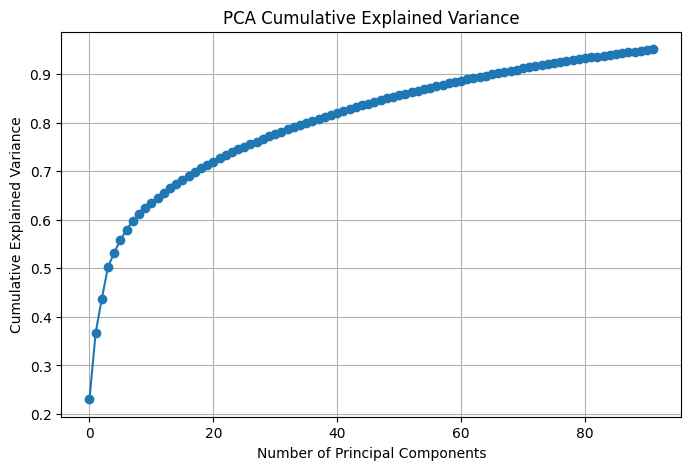

In [29]:
import matplotlib.pyplot as plt
import numpy as np

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.grid()
plt.show()

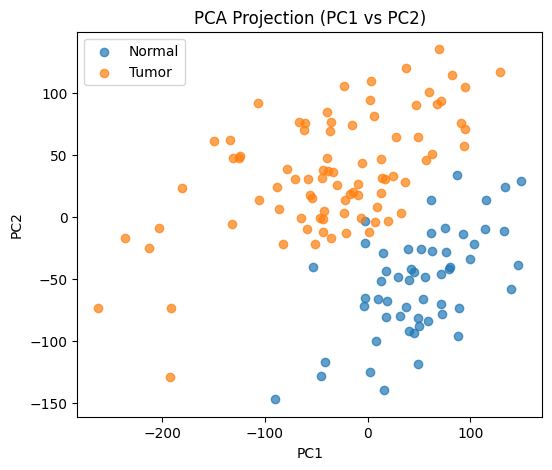

In [30]:
plt.figure(figsize=(6,5))

# First two PCs
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]

for label, color in zip([0,1], ['blue','red']):
    plt.scatter(
        pc1[y == label],
        pc2[y == label],
        label="Normal" if label==0 else "Tumor",
        alpha=0.7
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection (PC1 vs PC2)")
plt.legend()
plt.show()

## 4. Model Training

We train three supervised classification models:

- Logistic Regression  
- Linear Support Vector Machine (SVM)  
- Random Forest  

Data is split using stratified train-test split to preserve class distribution.

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (112, 92)
Test size: (28, 92)


In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

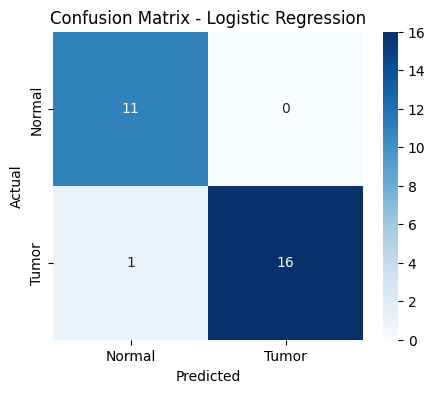

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_lr = lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Tumor"],
            yticklabels=["Normal","Tumor"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [25]:
from sklearn.svm import SVC

svm = SVC(kernel="linear", probability=True)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

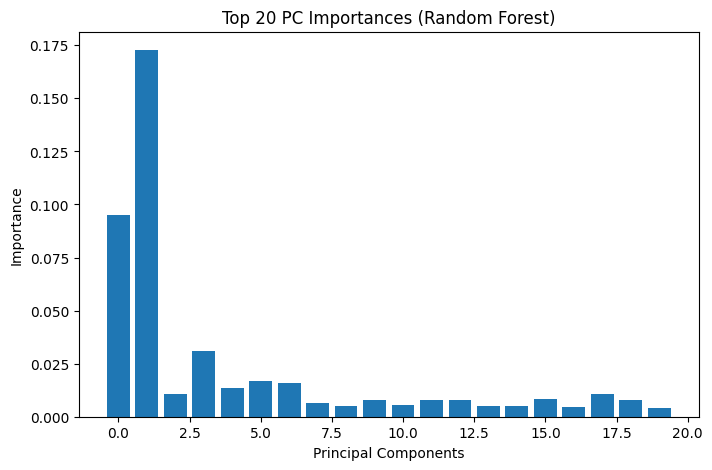

In [32]:
import pandas as pd

importance = rf.feature_importances_

plt.figure(figsize=(8,5))
plt.bar(range(20), importance[:20])
plt.xlabel("Principal Components")
plt.ylabel("Importance")
plt.title("Top 20 PC Importances (Random Forest)")
plt.show()

## 5. Model Evaluation

Model performance is evaluated using:

- Accuracy  
- ROC-AUC score  
- Precision, Recall, F1-score  
- Confusion Matrix  

Stratified 5-fold cross-validation is used to ensure robustness.

In [27]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

models = {
    "Logistic Regression": lr,
    "SVM": svm,
    "Random Forest": rf
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print("\n==============================")
    print(name)
    print("==============================")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print(classification_report(y_test, y_pred))


Logistic Regression
Accuracy: 0.9642857142857143
ROC-AUC: 0.9786096256684491
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.94      0.97        17

    accuracy                           0.96        28
   macro avg       0.96      0.97      0.96        28
weighted avg       0.97      0.96      0.96        28


SVM
Accuracy: 0.9285714285714286
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.89      1.00      0.94        17

    accuracy                           0.93        28
   macro avg       0.95      0.91      0.92        28
weighted avg       0.94      0.93      0.93        28


Random Forest
Accuracy: 0.9285714285714286
ROC-AUC: 0.9893048128342246
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.89      1.00      0

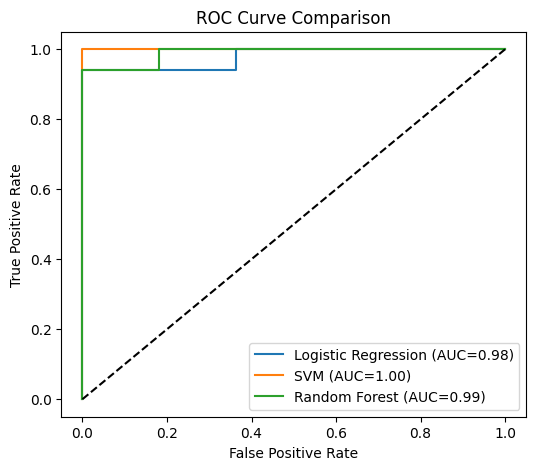

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(6,5))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

## Conclusion

Transcriptomic profiles clearly separate tumor and normal samples.  
Logistic Regression achieved 96% accuracy with ROC-AUC of 0.98, demonstrating strong discriminative power after dimensionality reduction.